In [41]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from common import NWSL, Fonts, Colors, add_twitter_handle, add_source

In [42]:
year = "2023"

In [43]:
# Read in the raw data
df = pd.read_csv("nwsl_" + year + ".csv")
df.head()

,name,club,country
0,Kailen Sheridan,San Diego Wave,Canada
1,Allysha Chapman,Houston Dash,Canada
2,Quinn,OL Reign,Canada
3,Sophie Schmidt,Houston Dash,Canada
4,Desiree Scott,Kansas City Current,Canada


In [44]:
# Perform data grouping
left = "country"
right = "club"
threshold = 0


def get_index(metric):
    index = df.groupby([metric]).agg(count=("name", "count")).reset_index()
    index.loc[index["count"] < threshold, metric] = "Other"
    index = (
        index.groupby([metric])
        .agg(count=("count", "sum"))
        .sort_values(["count", metric], ascending=[False, True])
        .reset_index()
    )
    index["y"] = list(
        map(
            lambda x: 0.5 * x/len(index["count"]) + 0.5 * (sum(index["count"][0:x]) + index["count"][x]*0.5) / sum(index["count"]),
            index.index,
        )
    )
    index = index.rename(columns={metric: "metric"})
    return index


left_index = get_index(left)
left_index["x"] = 0.001
right_index = get_index(right)
right_index["x"] = 0.999

nodes = pd.concat([left_index, right_index])

df_agg = df.copy()
df_agg[left] = df_agg[left].apply(
    lambda x: x if x in list(nodes["metric"]) else "Other"
)
df_agg[right] = df_agg[right].apply(
    lambda x: x if x in list(nodes["metric"]) else "Other"
)

df_agg = df_agg.groupby([left, right]).agg(count=("name", "count")).reset_index()

df_agg["color"] = df_agg["club"].apply(lambda x: NWSL.color(x))

df_agg[left] = df_agg[left].apply(lambda x: list(nodes["metric"]).index(x))
df_agg[right] = df_agg[right].apply(lambda x: list(nodes["metric"]).index(x))

In [45]:
# Create base sankey
link = dict(
    source=df_agg[left],
    target=df_agg[right],
    value=df_agg["count"],
    color=df_agg["color"]
)
node = dict(
    thickness=5,
    line=dict(color=Colors.LIGHT_GRAY),
    x=nodes["x"],
    y=nodes["y"],
    # label=nodes["metric"],
    color=Colors.LIGHT_GRAY,
)
data = go.Sankey(link=link, node=node)
fig = go.Figure(data, go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
))

fig.write_image("sankey_unlabeled_" + year + ".png", scale=4)

fig.show()

<Figure size 4800x4800 with 0 Axes>

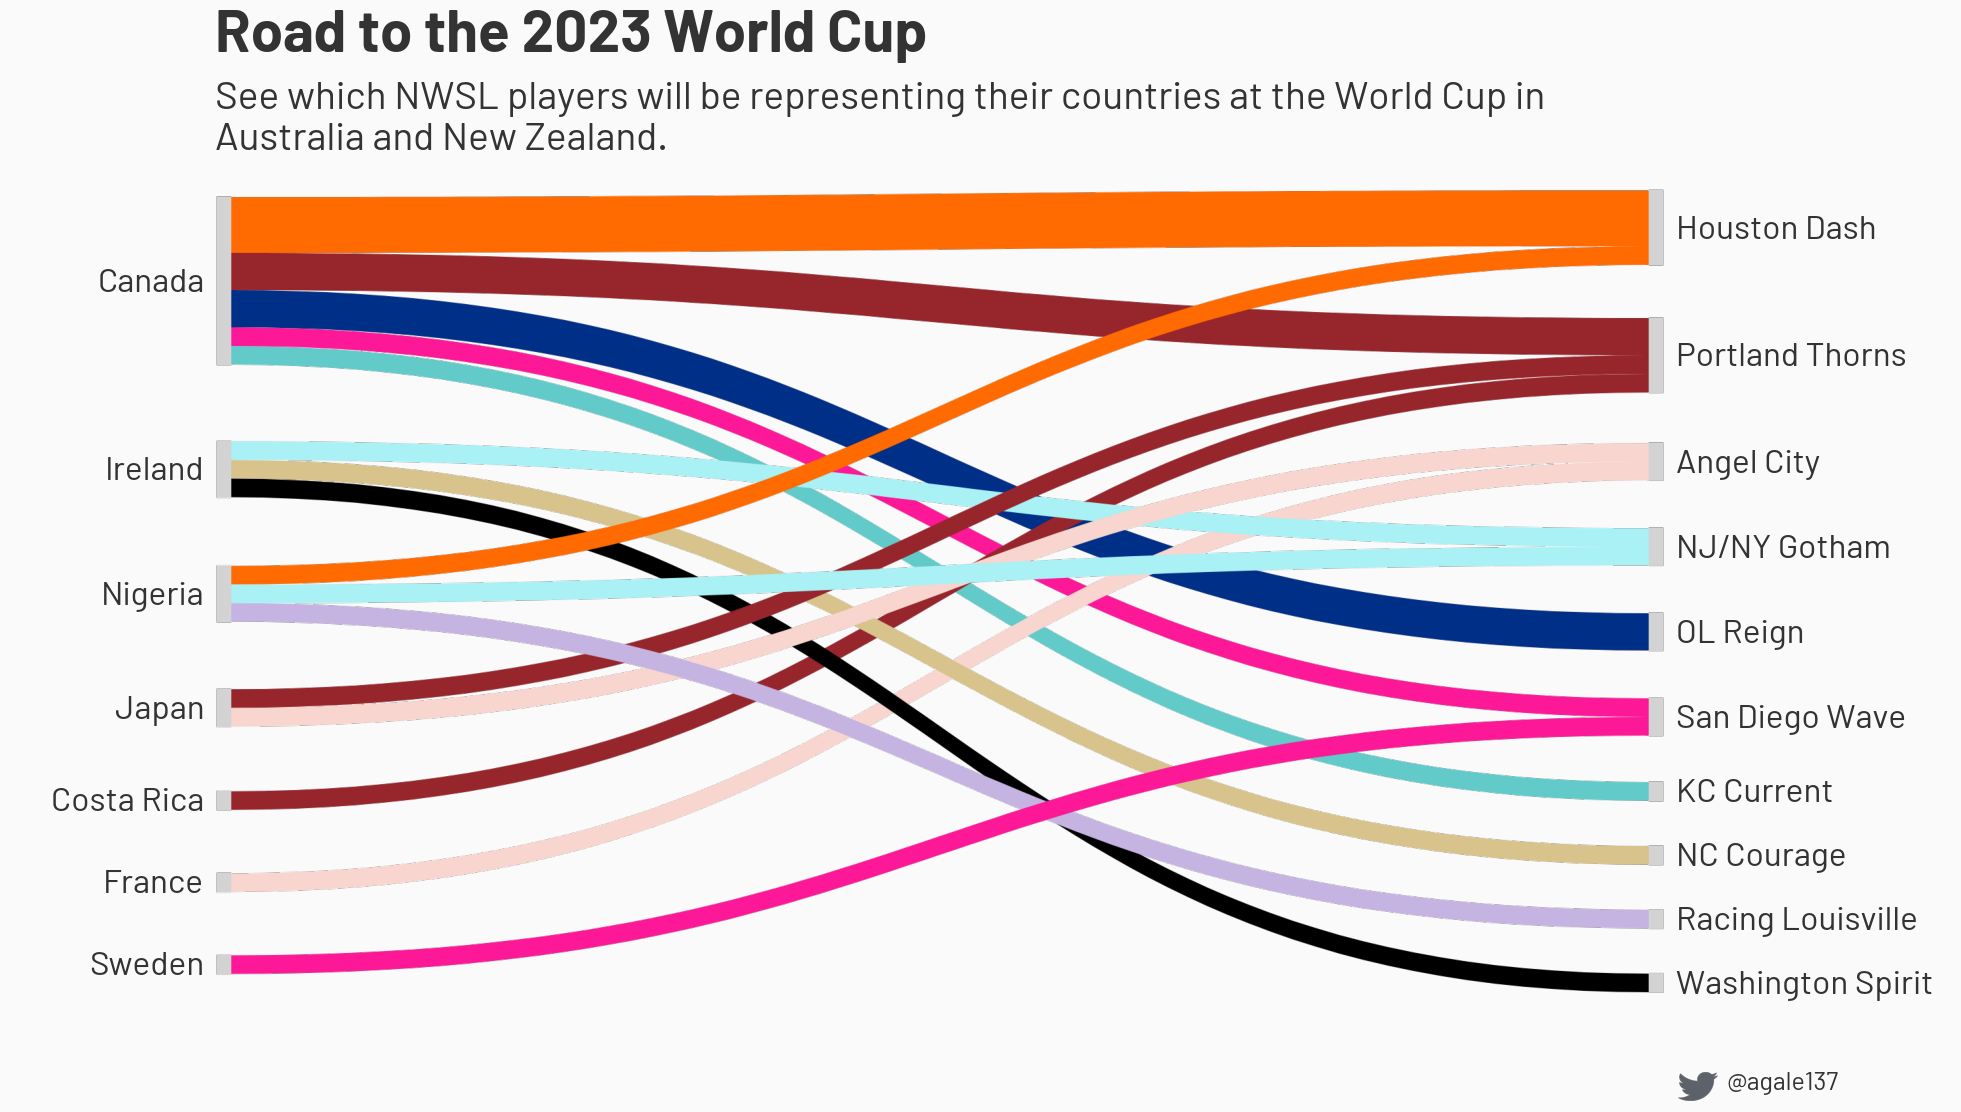

In [47]:
# Setup
plt.rcParams["figure.figsize"] = (24, 24)
plt.figure(dpi=200)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot image
img = mpimg.imread("sankey_unlabeled_" + year + ".png")
ax.imshow(img)

# Axes
ax.axis("off")
ax.set_ylim([1750, 255])

# Render the node labels
for i, row in nodes.iterrows():
    x = row["x"] * 2220 + 290
    y = row["y"] * 1280 + 415
    ha = "right" if row["x"] < 0.5 else "left"
    plt.text(x, y, NWSL.name(row["metric"]), ha=ha, fontproperties=Fonts.BARLOW, size=24, color=Colors.BLACK)

# Title
ax.set_title(
    "Road to the " + year + " World Cup",
    fontproperties=Fonts.BARLOW_BOLD,
    size=42,
    x=0.11,
    y=1.03,
    ha="left",
    color=Colors.BLACK,
)

# Subtitle
ax.text(
    0.11,
    0.94,
    #"The 2019 World Cup teams with the most NWSL players included the United States,\nAustralia, and Canada.",
    "See which NWSL players will be representing their countries at the World Cup in\nAustralia and New Zealand.",
    fontproperties=Fonts.BARLOW,
    size=28,
    ha="left",
    color=Colors.BLACK,
    transform=ax.transAxes,
)

add_twitter_handle(fig, x=0.82, y=0.28, fs=18, w=0.014)

# Save image
fig.savefig("sankey_" + year + ".png", bbox_inches="tight", pad_inches=0.5, dpi=200)